## For generating ED Figs. 5, 9d-f

In [1]:
import numpy as np
import numpy.matlib
from numpy.linalg import LinAlgError
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
from cycler import cycler
%matplotlib inline

ImportError: cannot import name 'SplineTransformer' from 'sklearn.preprocessing' (/home/adam/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/preprocessing/__init__.py)

In [2]:
from scipy import stats, ndimage
import dill
from copy import deepcopy
import cmocean
import time
from datetime import datetime
import json
import warnings

from statsmodels.formula.api import mixedlm

import os
import sys
sys.path.append('../GLM_Tensorflow_2/code')
import glm_class as glm

sys.path.append('../utils')
from paths import *
from db import select_db, get_db_info, execute_sql, insert_into_db, NumpyEncoder
from matio import loadmat
from protocols import load_params
from plotting import plot_stars, hide_spines, get_mouse_colors

from load_processed import load_processed
from analysisUtils import construct_where_str, assign_str_regions_from_kim
from glm_utils import *

sys.path.append('../behavior_analysis')
from traceUtils import check_stats

import joblib

In [3]:
plt.style.use('paper_export')
fmts = ['pdf', 'png']

### Load ephys sessions for all protocols

In [147]:
paths = get_db_info()
activity_type = 'spks'
table = 'ephys'

manipulation = 'combined'  #'6-OHDA'  # 'combined'  # 
protocols = ['SameRewDist']  #, 'Bernoulli', 'DiverseDists', 'SameRewVar'] 

min_size = 10
cutoff = .01

prot_colors = []
tt_names = []
all_neuron_info = pd.DataFrame()

In [148]:
if table == 'ephys':
    if manipulation == '6-OHDA':
        class_name = 'lesion'
        class_labels = ['control', 'lesioned']
        cls_palette = {'control': '#005363', 'lesioned': '#FF69B4'}
        # macro_palette = {'Ventral': 'k'}
    else:
        class_name = 'str_regions'
        class_labels = assign_str_regions_from_kim(None)
        class_labels = list(class_labels.keys())
        class_labels.remove('mAcbSh')
        cls_palette = {roi: plt.cm.plasma(i / (len(class_labels))) for i, roi in enumerate(class_labels)}
    macro_palette = {'Ventral': plt.cm.plasma(1 / len(class_labels)), 'Dorsal': plt.cm.plasma((len(class_labels) - 2) / len(class_labels))}
    macro_regions = ['Ventral', 'Dorsal']
    cell_types = ['MSN', 'FSI', 'TAN']
    
elif table == 'imaging':
    class_name = 'genotype'
    class_labels = ['D1-Cre', 'A2a-Cre']
    cls_palette = {'D1-Cre': '#FFA001', 'A2a-Cre': '#0A704E'}
    macro_palette = {'Ventral': 'k'}
    cell_types = ['MSN']

In [149]:
for protocol in protocols:
    colors, protocol_info, periods, kwargs = load_params(protocol)
    if protocol == 'SameRewDist' and table == 'ephys': kwargs['manipulation'] = manipulation
    prot_colors.append(colors['prot_color'])
    tt_names.append(protocol_info['trace_type_names'])
    
    # create SQL query based on keyword arguments passed to function
    _, sql = construct_where_str(protocol, kwargs, table)
    rets = execute_sql(sql, paths['db'])
    
    # deal with stats kwarg case, which requires reading in the entire JSONified string of the table
    alpha = periods['alpha']
    rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'], alpha)

    save_path = os.path.join(paths['home_root'], 'glm', '_'.join([protocol, table, str(manipulation), activity_type, 'glm_neuron_info' + '.sav']))
    if os.path.exists(save_path):
        print('Found saved vars at {}'.format(save_path))
        with open(save_path, 'rb') as f:
            neuron_info = joblib.load(f)
    else:
        raise Exception('Could not find file. Ensure it is copied to {}'.format(save_path))
                        
    if table == 'ephys':
        neuron_info, reg_labels = assign_str_regions_from_kim(neuron_info)
    else: 
        neuron_info = pd.DataFrame(neuron_info)
    
    neuron_info['protocol'] = protocol
    all_neuron_info = pd.concat([all_neuron_info, neuron_info])

all_neuron_info = all_neuron_info.reset_index()
tt_names = list(dict.fromkeys([x for subl in tt_names for x in subl]))

Found saved vars at ../../data/glm/SameRewDist_ephys_combined_spks_glm_neuron_info.sav


In [150]:
all_neuron_info

,index,names,file_dates,cluster_id,neuron_idx_good,neuron_idx_inc,fig_paths,depths,aps,mls,...,kim_region_ids,kim_generals,means,stds,cvs,kurtosis,cell_types,genotype,str_regions,protocol
0,0,AL39,20210930,0,0,0,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.629776,0.506758,-1.272312,...,835,VP,0.836002,2.737176,0.904367,1.780928,unidentified,BL/6J,VP,SameRewDist
1,1,AL39,20210930,2,2,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.554798,0.505883,-1.273910,...,2012,IPAC,0.696424,1.487058,0.319220,-1.638830,axonal,BL/6J,IPACM,SameRewDist
2,2,AL39,20210930,3,3,2,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.524807,0.505576,-1.274558,...,2012,IPAC,2.264476,2.659016,0.613775,0.092599,axonal,BL/6J,IPACM,SameRewDist
3,3,AL39,20210930,5,5,3,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.449827,0.505116,-1.276246,...,2372,IPAC,4.278591,4.149303,0.171514,-0.649585,axonal,BL/6J,lAcbSh,SameRewDist
4,4,AL39,20210930,8,7,5,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.404840,0.504840,-1.277259,...,2372,IPAC,1.512904,2.452640,0.774989,-1.698672,MSN,BL/6J,lAcbSh,SameRewDist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13992,13992,AL83,20220915,1103,653,288,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.770189,0.976379,-1.657884,...,2295,CP,0.427695,1.238420,0.725867,-1.233575,unidentified,BL/6J,DMS,SameRewDist
13993,13993,AL83,20220915,1104,654,289,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.770189,0.976379,-1.657884,...,2295,CP,0.238199,0.902315,0.654148,-1.341505,MSN,BL/6J,DMS,SameRewDist
13994,13994,AL83,20220915,1113,656,290,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.750189,0.976328,-1.657799,...,2295,CP,1.512872,2.252144,0.216975,-1.412753,MSN,BL/6J,DMS,SameRewDist
13995,13995,AL83,20220915,1116,658,292,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.710190,0.976225,-1.657629,...,1108,gcc,5.050876,5.400694,0.762188,-1.189977,MSN,BL/6J,gcc,SameRewDist


### Load glm_fit

In [151]:
if table == 'ephys':
    reg = 'group_lasso'
    se_frac = 0.75
    l1_ratio = 0.0  # not used, but in table
    dt = .020  # from streams/DataStream(). Will need to change if bin width changes!!
else:
    reg = 'group_lasso'
    se_frac = 0.75
    l1_ratio = 0.0
    dt = 1/15.24  # usual frame rate

In [152]:
fits_path = os.path.join(paths['home_root'], 'glm', '{}_glm_fit_table.sav'.format(table))
with open(fits_path, 'rb') as f:
    fits = joblib.load(f)

specs_path = os.path.join(paths['home_root'], 'glm', '{}_glm_model_specs.sav'.format(table))
with open(specs_path, 'rb') as f:
    model_specs = joblib.load(f)

In [153]:
fits

,mid,name,sid,rid,figure_path,exp_date,i_cell,se_frac,regularization,learning_rate,...,history_dev_expl_abl_nuissance,history_frac_expl_dev,history_frac_null_dev,reward_coefs,reward_dev,reward_dev_expl,reward_dev_abl_nuissance,reward_dev_expl_abl_nuissance,reward_frac_expl_dev,reward_frac_null_dev
0,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,0,0.75,group_lasso,0.005,...,0.211681,None,None,"[-3.6911105780745856e-06, 1.6042162314988673e-...",2943.355608,0.170018,2951.609731,0.167690,None,None
1,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,1,0.75,group_lasso,0.005,...,-0.000247,None,None,"[-1.0809242667164654e-05, 3.989565448137e-05, ...",673.342882,-0.000102,673.377705,-0.000154,None,None
2,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,2,0.75,group_lasso,0.005,...,0.046381,None,None,"[-1.1861087841680273e-05, -1.0780325283121783e...",6907.472760,0.050796,6949.578754,0.045009,None,None
3,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,3,0.75,group_lasso,0.005,...,0.015727,None,None,"[0.004137515090405941, 0.0020263863261789083, ...",5496.857532,0.012256,5512.822057,0.009387,None,None
4,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,4,0.75,group_lasso,0.005,...,0.159238,None,None,"[0.011417734436690807, 0.02967837266623974, 0....",3001.872571,0.172651,3083.288249,0.150212,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53710,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,260,0.75,group_lasso,0.005,...,0.035144,None,None,"[-0.0016615733038634062, -0.001012755092233419...",693.858550,0.047650,707.202518,0.029335,None,None
53711,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,261,0.75,group_lasso,0.005,...,0.080609,None,None,"[4.97207474836614e-06, 9.614151394998771e-07, ...",1692.786731,0.195713,1942.139192,0.077239,None,None
53712,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,262,0.75,group_lasso,0.005,...,0.001327,None,None,"[-1.1019245903298724e-05, -1.657992834225297e-...",3453.776729,0.026259,3542.432902,0.001263,None,None
53713,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,263,0.75,group_lasso,0.005,...,0.009877,None,None,"[2.8223494155099615e-06, 1.6235422663157806e-0...",11318.501899,0.010114,11357.317087,0.006719,None,None


In [154]:
model_specs

,mid,name,sid,rid,figure_path,exp_date,i_model,protocol,fit_date,n_trial,...,optimizer,learning_rate,fitting_time,dropped_out_vars,regressor_labels,se_frac,l1_ratio,dt,seed,modality
0,54,AL17,52,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20210331,0,Bernoulli,20240408.0,207,...,adam,0.005,117.406330,history,"[""time_in_trialbump0"", ""time_in_trialbump1"", ""...",0.75,0.0,0.02,5452,ephys
1,54,AL17,61,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20210418,0,ShockBernoulli,20240408.0,291,...,adam,0.005,152.309401,history,"[""time_in_trialbump0"", ""time_in_trialbump1"", ""...",0.75,0.0,0.02,5461,ephys
2,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,0,Bernoulli,20240408.0,198,...,adam,0.005,150.975731,none,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,6312,ephys
3,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,0,Bernoulli,20240611.0,198,...,adam,0.005,151.296997,reward,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,6312,ephys
4,63,AL23,12,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20201215,1,Bernoulli,20240408.0,198,...,adam,0.005,136.565958,licking,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,6312,ephys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,0,SameRewVar,20240611.0,266,...,adam,0.005,203.710356,reward,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,16426,ephys
1384,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,1,SameRewVar,20240602.0,266,...,adam,0.005,434.221807,licking,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,16426,ephys
1385,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,2,SameRewVar,20240602.0,266,...,adam,0.005,427.738265,expectiles,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,16426,ephys
1386,164,AL105,26,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,20240427,3,SameRewVar,20240602.0,266,...,adam,0.005,378.480604,motor,"[""1-back reward magnitudebump0"", ""1-back rewar...",0.75,0.0,0.02,16426,ephys


### Merge tables

In [155]:
if table == 'ephys':
    all_neuron_info['macro_regions'] = None
    all_neuron_info.loc[np.isin(all_neuron_info['str_regions'], ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core']), 'macro_regions'] = 'Ventral'
    all_neuron_info.loc[np.isin(all_neuron_info['str_regions'], ['VMS', 'VLS', 'DMS', 'DLS']), 'macro_regions'] = 'Dorsal'
else:
    all_neuron_info['macro_regions'] = 'Ventral'
    all_neuron_info['cell_types'] = 'MSN'


if manipulation == '6-OHDA':
    all_neuron_info['hemi'] = False
    all_neuron_info.loc[all_neuron_info['mls'] > 0, 'hemi'] = True

    all_neuron_info['lesion'] = None
    mice = np.unique(all_neuron_info['names'])
    lesion_rets = select_db(paths['db'], 'lesion', '*', 'lesion="6-OHDA"', (), unique=False)
    for lret in lesion_rets:
        if lret['name'] in mice:
            larea_mouse = np.logical_and.reduce([all_neuron_info.depths > lret['bregma_bottom'], 
                                                 all_neuron_info.depths < lret['bregma_top'],
                                                 all_neuron_info.names == lret['name']])
            all_neuron_info.loc[np.logical_and(larea_mouse, all_neuron_info.hemi), 'lesion'] = 'lesioned'
            all_neuron_info.loc[np.logical_and(larea_mouse, ~all_neuron_info.hemi), 'lesion'] = 'control'
    print('lesion marked')

In [156]:
merge = all_neuron_info.merge(fits, 'inner', left_on=['names', 'file_dates', 'neuron_idx_inc'], right_on=['name', 'exp_date', 'i_cell']).drop_duplicates(subset=['name', 'exp_date', 'i_cell'])
merge = merge.merge(full_model_specs[['name', 'exp_date', 'regressor_labels']], 'left', on=['name', 'exp_date']) 

In [157]:
mc = [get_mouse_colors(protocol, True) if table == 'imaging' else get_mouse_colors(protocol) for protocol in protocols]
mouse_colors = {k: v for d in mc for k, v in d.items()}
subs = ['all', 'history', 'expectiles', 'motor', 'reward']
subs_palette = {k: v for k, v in zip(subs, [[.3]*3, '#ef9b20', '#87bc45', '#b33dc6', '#85C1E9'])}
drop_vars = subs[1:]
drop_palette = [v for k, v in subs_palette.items() if k != 'all']

drop_abbrvs = ['h', 'e', 'm', 'r']
drop_tups = [(l, m) for i, l in enumerate(drop_abbrvs) for m in drop_abbrvs[:i]]

drop_tunings = ['abs_' + x if x == 'expectiles' else x for x in drop_vars]

# Compute difference in deviance explained upon holding out expectiles (or motor or trial history), as well as the kernel magnitudes for each expectile

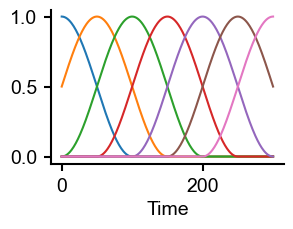

In [158]:
merge['trim_dev_expl'] = merge['full_dev_expl_abl_nuissance']
merge.loc[merge['trim_dev_expl'] < -1, 'trim_dev_expl'] = -1
# get filters, in order to compute kernels later
filts, pred_filts, filt_time = get_filts(dt)
n_filts = filts.shape[1]

n_bases = 7
nsamps_per_trial = int(np.around(6/dt))  # check that this is 91 in the imaging case and that this matches the neural data from DataStream
bases, basis_widths, basis_centers = create_basis(nsamps_per_trial, n_bases)
# basis_time = np.arange(-1, 5, dt)
basis_time = np.linspace(-1, 5, nsamps_per_trial)

# create columns for expectile tuning in merge df
taus = np.linspace(.1, .9, 5)
tau_strs = ['{:.1f}-tau tuning'.format(tau) for tau in taus]
merge[tau_strs] = np.nan
merge['pref_tau'] = np.nan

# create columns for history tuning in merge df
history_columns = [f'{n}-back {var}' for var in ['reward magnitude', 'mean', 'RPE'] for n in range(1, 3)]
merge[history_columns] = np.nan

# create columns for reward tuning in merge df
reward_columns = [f'{var}' for var in ['Reward present', 'Reward magnitude', 'RPE']]
merge[reward_columns] = np.nan

# create columns for motor tuning in merge df
all_conv_labels = ['Licking', 'running', 'whisking']
all_conv_columns = np.array([[conv_label + ' tuning', conv_label + '_pred tuning'] for conv_label in all_conv_labels], dtype=object).flatten()
merge[all_conv_columns] = np.nan

dir_labels = ['mot_svd', 'pupil']
merge[dir_labels] = np.nan
motor_candidates = dir_labels + all_conv_labels

# create dictionary to retain coefficients, for later dimensionality reduction/clustering
prot_coefs = {prot: {'coefs': [], 'labels': [], 'name': [], 'exp_date': [], 'figure_path': [], 
                     'i_cell': [], class_name: [], 'macro_regions': [], 'cell_types': []} for prot in protocols}
svd_coefs = {prot: {'coefs': np.empty((0, 50)), 'name': [], 'exp_date': [], 'figure_path': [],
                    'i_cell': [], class_name: [], 'macro_regions': [], 'cell_types': []} for prot in protocols}


In [159]:
# iterate through each full model
for i_row, row in full_model_specs.iterrows():
    # print(i_row)
    # get the relevant rows from merge
    merge_inds = np.logical_and(merge['name'] == row['name'], merge['exp_date'] == row['exp_date'])
    neurons = merge[merge_inds].reset_index(drop=True)
    # if the model has good_neurons associated with it (significant behavior session especially)
    if len(neurons) > 0:
        # get the labels for each regressor for that model, then group the labels in various ways with boolean arrays
        # which will be handy later
        labels = np.array(json.loads(row['regressor_labels']))
        expectile_labels = np.array(['expectile' in coef_name for coef_name in labels])
        history_labels = np.array(['-back' in coef_name for coef_name in labels])
        motor_groups = np.array([[candidate in coef_name for coef_name in labels] for candidate in motor_candidates])
        motor_labels = np.logical_or.reduce(motor_groups)
        # non_pupil_labels = np.array(['pupil' not in coef_name for coef_name in labels])
        mot_svd_labels = np.array(['mot_svd' in coef_name for coef_name in labels])
        reward_labels = np.array(['Reward' in coef_name or 'RPEfilt' in coef_name for coef_name in labels])

        # count number of expectile, motor, history, and reward groups
        n_expectiles = len(np.unique([lab[:-5] for lab in labels[expectile_labels]]))
        n_motor = np.sum([np.any(x) for x in motor_groups])
        n_history = len(np.unique([lab[:-5] for lab in labels[history_labels]]))
        n_reward = len(np.unique([lab[:-5] for lab in labels[reward_labels]]))

        # print(n_reward, labels[reward_labels])

        # extract all coefficients, row by row
        all_coefs = np.array([json.loads(neuron['full_coefs']) for _, neuron in neurons.iterrows()])

        # store coefficients, labels, and other info in prot_coefs dict. If pupil doesn't exist, make it zero
        # these are from neurons, which is from merge, so it only is using 'good cells'
        if np.any(mot_svd_labels):

            # to plot the decay of svd_coefs
            prot = neurons.loc[0, 'protocol']
            svd_coefs[prot]['coefs'] = np.vstack((svd_coefs[prot]['coefs'], np.abs(all_coefs[:, mot_svd_labels])))
            
            n_coefs_no_alter = list(labels).index('running_predfilt4') + 1
            # mot_svd_coefs = np.sum(np.abs(all_coefs[:, mot_svd_labels]), axis=1)
            pupil_coefs = np.zeros(all_coefs.shape[0]) if 'pupil' not in labels else all_coefs[:, list(labels).index('pupil')]

            # prot_c = np.hstack((all_coefs[:, :n_coefs_no_alter], mot_svd_coefs.reshape(-1, 1), pupil_coefs.reshape(-1, 1)))
            # prot_labels = np.concatenate((labels[:n_coefs_no_alter], ['mot_svd', 'pupil']))

            # DON'T include mot_svd for the coefficients since they're not aligned across sessions
            prot_c = np.hstack((all_coefs[:, :n_coefs_no_alter], pupil_coefs.reshape(-1, 1)))
            prot_labels = np.concatenate((labels[:n_coefs_no_alter], ['pupil']))
            
            prot_coefs[prot]['coefs'] = prot_c if len(prot_coefs[prot]['coefs']) == 0 else \
                np.vstack((prot_coefs[prot]['coefs'], prot_c))
            prot_coefs[prot]['labels'] = prot_labels.reshape(1, -1) if len(prot_coefs[prot]['labels']) == 0 else \
                np.vstack((prot_coefs[prot]['labels'], prot_labels.reshape(1, -1)))
            for key in ['name', 'exp_date', 'figure_path', 'i_cell', class_name, 'macro_regions', 'cell_types']:
                for use_dict in svd_coefs, prot_coefs:
                    # use_dict[prot][key].extend(np.repeat(row[key], neurons.shape[0]))
                    use_dict[prot][key].extend(neurons[key])
            # prot_coefs[prot]['i_cell'].extend(neurons['i_cell'])
            # prot_coefs[prot]['str_regions'].extend(neurons['str_regions'])
            # prot_coefs[prot]['macro_regions'].extend(neurons['macro_regions'])
        
        # extract specific coefficients
        expectile_coefs = all_coefs[:, expectile_labels]
        expectile_coefs_by_tau = expectile_coefs.reshape((neurons.shape[0], n_expectiles, n_filts))
        history_coefs = all_coefs[:, history_labels]
        history_coefs_by_var = history_coefs.reshape((neurons.shape[0], n_history, n_bases))
        reward_coefs = all_coefs[:, reward_labels]
        reward_coefs_by_var = reward_coefs.reshape((neurons.shape[0], n_reward, n_filts))
        motor_coefs = all_coefs[:, motor_labels]
        
        if n_expectiles == 1:  # SameRewSize protocol only has one expectile. NaN out the others
            expectile_coefs_by_tau = np.concatenate((np.full((neurons.shape[0], 2, n_filts), np.nan),
                                                     expectile_coefs_by_tau,
                                                     np.full((neurons.shape[0], 2, n_filts), np.nan)), axis=1)
        
        # compute expectile kernels for all neurons. For now, not taking absolute value
        expectile_expansion = filts[:, np.newaxis, np.newaxis, :] * expectile_coefs_by_tau[np.newaxis, :, :, :]
        # expectile_tuning = np.abs(np.sum(expectile_expansion, axis=3))  # sum over filters to get the kernel, then take the absolute value
        expectile_tuning = np.sum(expectile_expansion, axis=3)  # sum over filters to get the kernel
        expectile_int = np.trapz(expectile_tuning, x=filt_time, axis=0)  # integrate over time points to get an overall amount of tuning

        # compute history kernels for all neurons
        history_expansion = bases[:, np.newaxis, np.newaxis, :] * history_coefs_by_var[np.newaxis, :, :, :]
        history_tuning = np.sum(history_expansion, axis=3)  # sum over filters to get the kernel
        history_int = np.trapz(history_tuning, x=basis_time, axis=0)  # integrate over time points to get an overall amount of tuning

        reward_expansion = filts[:, np.newaxis, np.newaxis, :] * reward_coefs_by_var[np.newaxis, :, :, :]
        reward_tuning = np.sum(reward_expansion, axis=3)
        reward_int = np.trapz(reward_tuning, x=filt_time, axis=0)
        
        # compute motor kernels for all neurons where applicable, which is to say, Licking, Licking_pred, running, running_pred, 
        # whisking, and whisking_pred
        motor_expansion = np.empty((len(filt_time), neurons.shape[0], 0, n_filts))
        pred_labels = np.array(['pred' in coef_name for coef_name in labels[motor_labels]])
        conv_columns = []
        for conv_label in all_conv_labels:
            sub_labels = [conv_label in coef_name for coef_name in labels[motor_labels]]
            subpred_labels = np.logical_and(sub_labels, pred_labels)
            subresp_labels = np.logical_and(sub_labels, ~pred_labels)
            if np.sum(subpred_labels) == n_filts and np.sum(subresp_labels) == n_filts:
                conv_columns.extend([conv_label + ' tuning', conv_label + '_pred tuning'])
                pred_expansion = pred_filts[:, np.newaxis, np.newaxis, :] * motor_coefs[np.newaxis, :, np.newaxis, subpred_labels]
                resp_expansion = filts[:, np.newaxis, np.newaxis, :] * motor_coefs[np.newaxis, :, np.newaxis, subresp_labels]
                motor_expansion = np.concatenate((motor_expansion, pred_expansion, resp_expansion), axis=2)
        motor_tuning = np.sum(motor_expansion, axis=3)  # sum over filters to get the kernel
        motor_int = np.trapz(motor_tuning, x=filt_time, axis=0)  # integrate over time points to get an overall amount of tuning

        # add integrated kernels to merge df
        merge.loc[merge_inds, tau_strs] = expectile_int
        # merge.loc[merge_inds, 'pref_tau'] = taus[np.argmax(expectile_int, axis=1)]
        # merge.loc[merge_inds, 'pref_tau'] = np.sum(taus[np.newaxis, :] * expectile_int, axis=1) / np.sum(expectile_int, axis=1)
        # compute preferred tau, weighted by the absolute value of the integrated kernels
        merge.loc[merge_inds, 'pref_tau'] = np.sum(taus[np.newaxis, :] * np.abs(expectile_int), axis=1) / np.sum(np.abs(expectile_int), axis=1)

        merge.loc[merge_inds, history_columns] = history_int
        merge.loc[merge_inds, reward_columns[3-n_reward:]] = reward_int  # because Reward present, which is at index 0, is missing from Bernoulli
        
        merge.loc[merge_inds, conv_columns] = motor_int
        if 'pupil' in labels: merge.loc[merge_inds, 'pupil'] = all_coefs[:, list(labels).index('pupil')]
        if np.any(motor_groups[0]): merge.loc[merge_inds, 'mot_svd'] = np.sum(all_coefs[:, motor_groups[0]], axis=1) 

# compute total tuning as the sum across different taus
merge['total_expectiles_tuning'] = np.sum(merge[tau_strs], axis=1)
merge['total_abs_expectiles_tuning'] = np.abs(merge['total_expectiles_tuning'])
merge['sign_expectiles_tuning'] = np.sign(merge['total_expectiles_tuning'])

merge['total_history_tuning'] = np.sum(np.abs(merge[history_columns]), axis=1)
merge['total_reward_tuning'] = np.sum(np.abs(merge[reward_columns]), axis=1)

# for cols, name in zip([['pupil', 'mot_svd'], ['whisking tuning', 'whisking_pred tuning'], ['Licking tuning', 'Licking_pred tuning'], []],
#                       ['mot_svd_pupil', 'whisking', 'licking', 'orofacial', 'running', 
# compute the total motor tuning to different variables, taking the absolute value when necessary to ensure positive summation
merge['total_mot_svd_pupil_tuning'] = np.nansum(np.abs(merge[['pupil', 'mot_svd']]), axis=1)
merge['total_whisking_tuning'] = np.nansum(merge[['whisking tuning', 'whisking_pred tuning']], axis=1)
merge['total_licking_tuning'] = np.nansum(merge[['Licking tuning', 'Licking_pred tuning']], axis=1)
merge['total_whisking_licking_tuning'] = np.abs(merge['total_whisking_tuning']) + np.abs(merge['total_licking_tuning'])
merge['total_orofacial_tuning'] = merge['total_mot_svd_pupil_tuning'] + merge['total_whisking_licking_tuning']

merge['total_running_tuning'] = np.nansum(merge[['running tuning', 'running_pred tuning']], axis=1)
merge['total_conv_tuning'] = merge['total_whisking_licking_tuning'] + np.abs(merge['total_running_tuning'])
merge['total_motor_tuning'] = merge['total_orofacial_tuning'] + np.abs(merge['total_running_tuning'])
merge['frac_orofacial_tuning'] = merge['total_orofacial_tuning'] / merge['total_motor_tuning']

assert np.all([np.all(prot_coefs[protocol]['labels'][0] == prot_coefs[protocol]['labels']) for protocol in protocols])

In [161]:
for label in ['expectiles', 'motor', 'history', 'reward']:
    merge[f'{label}_trim_dev_expl'] = merge[f'{label}_dev_expl_abl_nuissance']
    merge.loc[merge[f'{label}_trim_dev_expl'] < -1, f'{label}_trim_dev_expl'] = -1
    merge[f'{label}_diff'] = merge['trim_dev_expl'] - merge[f'{label}_trim_dev_expl']
    merge[f'{label}_inds'] = np.logical_and.reduce([merge[f'{label}_diff'] > .01, merge[f'{label}_trim_dev_expl'] > 0, 
                                                    np.abs(merge[f'total_{label}_tuning']) > .1])

In [162]:
filt_merge = merge[np.isin(merge[class_name], class_labels)]
sess_avg_merge = filt_merge.groupby(['protocol', class_name, 'names', 'file_dates'], as_index=False).mean(numeric_only=True)
mouse_avg_merge = sess_avg_merge.groupby(['protocol', class_name, 'names'], as_index=False).mean(numeric_only=True)
grand_avg_merge = mouse_avg_merge.groupby(['protocol', class_name]).mean(numeric_only=True)
grand_std_merge = mouse_avg_merge.groupby(['protocol', class_name]).std(numeric_only=True)

In [163]:
grand_avg_merge[[f'{var}_diff' for var in drop_vars]]

history_diff  expectiles_diff  motor_diff  \
protocol    str_regions                                              
SameRewDist DLS             -0.000784         0.001874    0.071704   
            DMS             -0.000301         0.001489    0.058528   
            OT               0.005979         0.010890    0.022700   
            VLS              0.003293         0.011047    0.053965   
            VMS              0.003453         0.010200    0.049701   
            VP               0.002554         0.006400    0.020003   
            core             0.003215         0.013829    0.029561   
            lAcbSh           0.004287         0.010807    0.033523   

                         reward_diff  
protocol    str_regions               
SameRewDist DLS             0.003131  
            DMS             0.003834  
            OT              0.007781  
            VLS             0.009095  
            VMS             0.007152  
            VP              0.004118  
            core            0.009484  
            lAcbSh          0.009045

In [164]:
grand_std_merge[[f'{var}_diff' for var in drop_vars]]

history_diff  expectiles_diff  motor_diff  \
protocol    str_regions                                              
SameRewDist DLS              0.001970         0.002105    0.037159   
            DMS              0.003162         0.001788    0.031919   
            OT               0.005518         0.009375    0.013635   
            VLS              0.002697         0.007972    0.021377   
            VMS              0.002852         0.006682    0.025123   
            VP               0.003344         0.005379    0.011185   
            core             0.002532         0.010116    0.024489   
            lAcbSh           0.003647         0.010462    0.020352   

                         reward_diff  
protocol    str_regions               
SameRewDist DLS             0.003997  
            DMS             0.001760  
            OT              0.007037  
            VLS             0.004852  
            VMS             0.003612  
            VP              0.003515  
            core            0.006283  
            lAcbSh          0.005349

SameRewDist


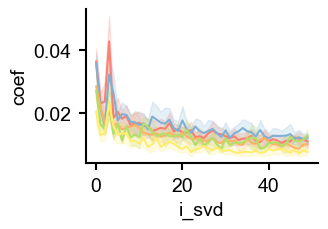

In [100]:
# b/c the mot_svds are not ordered across sessions, plot their decay on average
coef_dfs = {}
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for prot in protocols:
    print(prot)
    
    prot_df = pd.DataFrame(svd_coefs[prot], columns=['name', 'exp_date', 'figure_path'])
    prot_df[np.arange(svd_coefs[prot]['coefs'].shape[1])] = svd_coefs[prot]['coefs']
    sess_avg_prot_df = prot_df.groupby(['name', 'exp_date', 'figure_path'], as_index=False).mean()
    sess_avg_prot_df = sess_avg_prot_df.melt(id_vars=['name', 'exp_date', 'figure_path'], var_name='i_svd', value_name='coef')
    
    plt.figure()
    sns.lineplot(data=sess_avg_prot_df, x='i_svd', y='coef', hue='name', palette=mouse_colors, legend=False)

    columns = ['name', 'exp_date', 'figure_path', 'i_cell', class_name, 'macro_regions', 'cell_types']
    prot_df = pd.DataFrame(prot_coefs[prot], columns=columns)
    prot_df[prot_coefs[prot]['labels'][0]] = prot_coefs[prot]['coefs']
    coef_dfs[prot] = prot_df
hide_spines()

In [101]:
for protocol in protocols:
    print(protocol)
    prot_inds = merge['protocol'] == protocol
    for label in ['expectiles', 'motor', 'history', 'reward']:
        print(label, np.mean(np.logical_and(merge[f'{label}_inds'], prot_inds)))
    print('Median', np.nanmedian(merge.loc[prot_inds, 'full_dev_expl']))
    print('90th %', np.nanpercentile(merge.loc[prot_inds, 'full_dev_expl'], 90))

SameRewDist
expectiles 0.1542781631978857
motor 0.4859596960687149
history 0.07058693976434313
reward 0.16473956612707852
Median 0.09627744161861118
90th % 0.30728290340123665


In [102]:
if table == 'ephys':
    merge.sort_values('total_expectiles_tuning')[['names', 'file_dates', 'neuron_idx_inc', 'means', 'protocol', 'total_expectiles_tuning']].iloc[-50:]

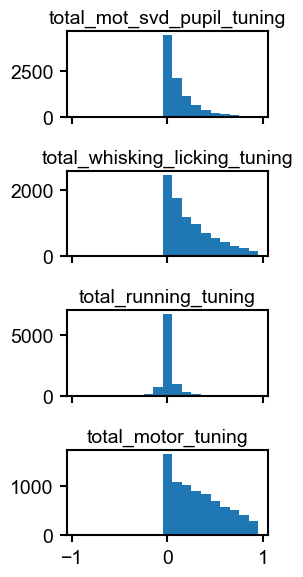

In [103]:
bin_edges = np.linspace(-.95, .95, 20)
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3,6))
for i_ax, motorvar in enumerate(['total_mot_svd_pupil_tuning', 'total_whisking_licking_tuning', 'total_running_tuning', 'total_motor_tuning']):
    axs[i_ax].hist(merge[motorvar], bin_edges)
    axs[i_ax].set_title(motorvar)
fig.tight_layout()

### Start analysis. Plot frac deviance explained for all neurons, and broken up by striatal subregion or ventral/dorsal (ACB/CP) or genotype, as well as distribution of taus

[None, None]

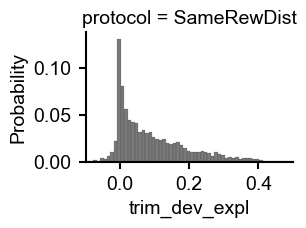

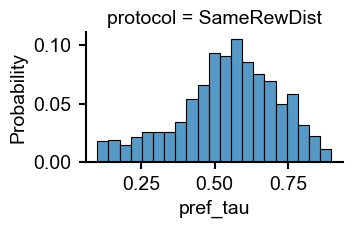

In [104]:
# excluding nuissance regressors, therefore a fairer estimate of "meaningful" variability
hist_kwargs = {'kind': 'hist', 'stat': 'probability', 'common_norm': False} 
hist_kwargs = {'col': 'protocol', 'col_order': protocols, **hist_kwargs} if table == 'ephys' else {'col': class_name, 'col_order': class_labels, **hist_kwargs} 

g = sns.displot(data=merge, x='trim_dev_expl', color=[.3]*3, binwidth=.01, height=2.5, aspect=1.3, **hist_kwargs)
g.set(xlim=[-.1, .5])
[plt.savefig('./glm_figs/trim_dev_expl_hist_reg_{}_l1_{}.{}'.format(reg, l1_ratio, ext)) for ext in fmts]

g = sns.displot(data=merge[merge['expectiles_inds']], x='pref_tau', height=2.5, aspect=1.5, **hist_kwargs)
[plt.savefig('./glm_figs/pref_tau_expectiles_inds_hist_reg_{}_l1_{}.{}'.format(reg, l1_ratio, ext)) for ext in fmts]

In [105]:
all_df = pd.DataFrame()
drop_df = pd.DataFrame()

for drop_var in subs:  # looking at the subsets independently
    # looking at the differences and tuning
    data = merge.copy()
    data['drop_var'] = drop_var
    if drop_var == 'all':
        data['diff'] = 0
        data['tuning'] = 0
        all_df = pd.concat((all_df, data))
    else:
        data['diff'] = data[drop_var+'_diff']
        data['tuning'] = data['_'.join(['total', drop_var, 'tuning'])]
        all_df = pd.concat((all_df, data))

        for i, (inds, hist_var, binw, xlim, sub) in enumerate(zip([np.ones(merge.shape[0], dtype=bool), merge[drop_var+'_inds'], merge[drop_var+'_inds']],
                                                   [drop_var+'_diff', drop_var+'_diff', '_'.join(['total', drop_var, 'tuning'])],
                                                   [.001, .002, .1], [(-.02, .07), (0, .3), (-2.5, 2.5)], ['all', drop_var, drop_var])):
    
            inds_data = data[inds]       
                    
            # g = sns.displot(data=data, x=hist_var, binwidth=binw, height=2.5, **hist_kwargs).set_titles("{col_name}")
            # g.set(xlim=xlim)
            # [plt.savefig('./glm_figs/{}_diff_{}_inds_hist_reg_{}_l1_{}.{}'.format(drop_var, sub, reg, l1_ratio, ext)) for ext in fmts]
            
            if hist_var == '_'.join(['total', drop_var, 'tuning']):
                # print(data.shape)
                drop_df = pd.concat((drop_df, inds_data))
                



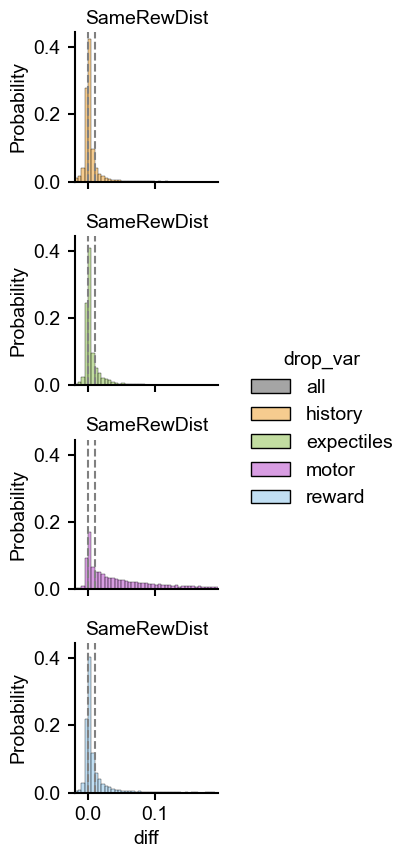

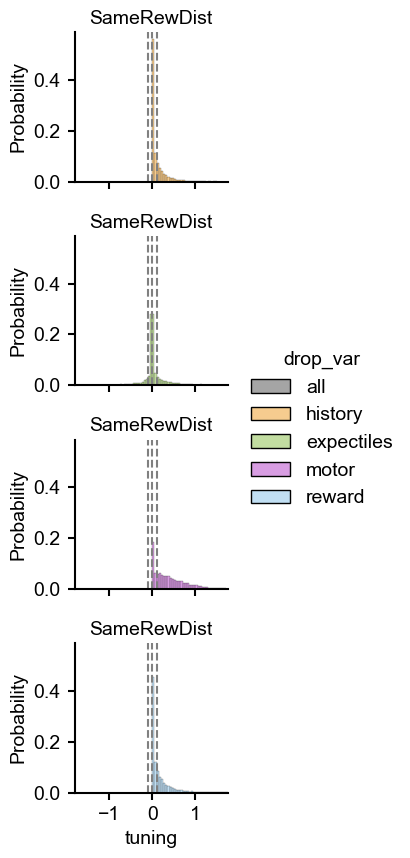

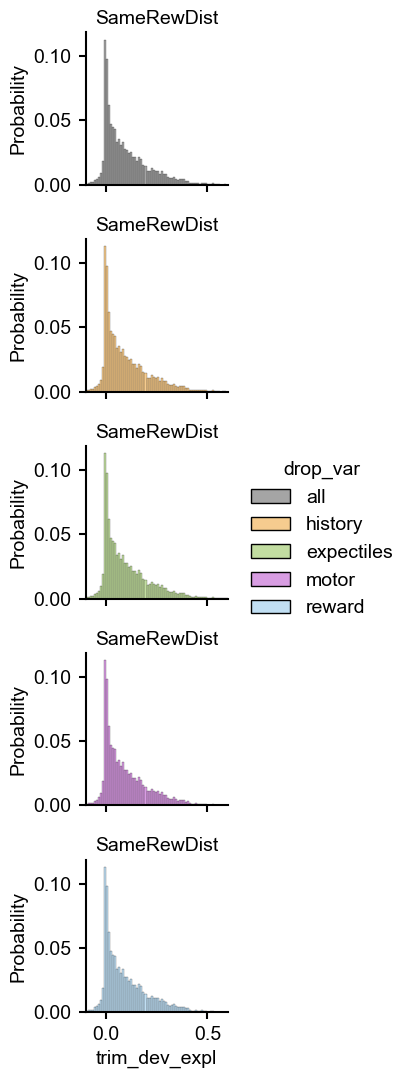

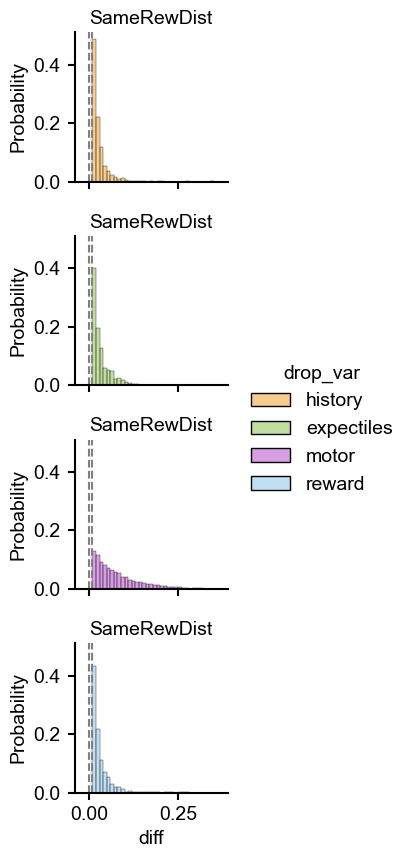

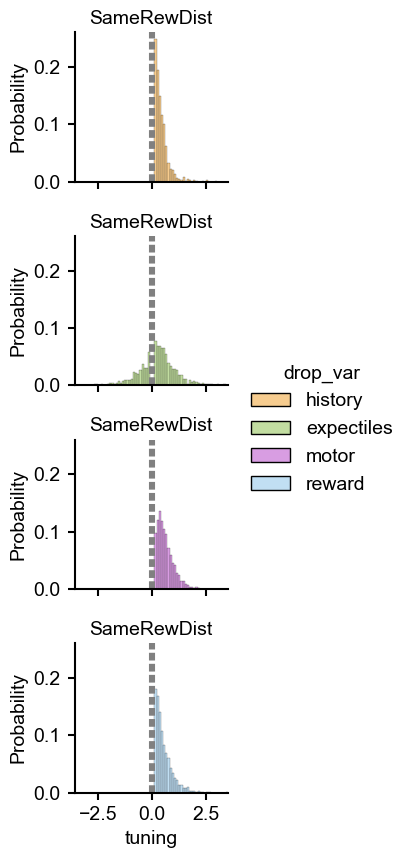

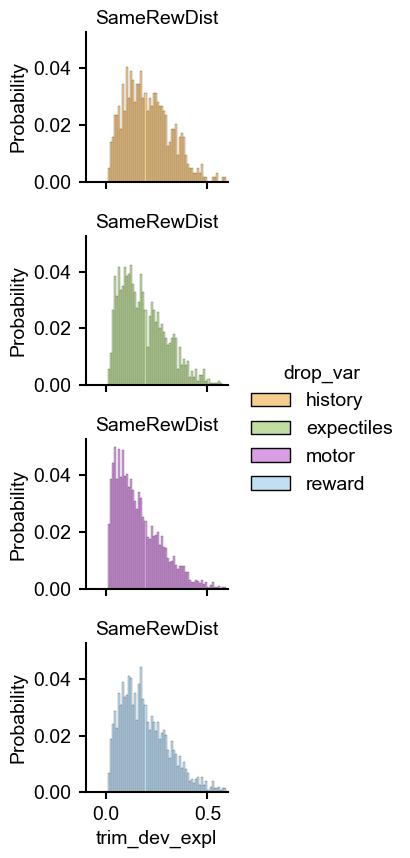

In [106]:
lin = True  # whether to use linear or log scaling
if lin:
    diff_bins = np.arange(-.02, .2, .005)
    tuning_bins = np.arange(-1.8, 1.8, .05)
else:
    diff_bins = np.arange(-.05, .3, .005)
    tuning_bins = np.arange(-3, 3, .05)

trim_dev_bins = np.linspace(-.1, .6, 71)

for df, bins, inds_name, row_orders in zip([all_df.reset_index(), drop_df],
                                     [[diff_bins, tuning_bins, trim_dev_bins], [diff_bins*2, tuning_bins*2, trim_dev_bins]],
                                     # [[(-.05, .3), (-3, 3), (-.1, .6)], [(-.05, .3), (-3, 3), (-.1, .6)]],
                                     ['all', 'subset'], [[drop_vars, drop_vars, subs], [drop_vars, drop_vars, drop_vars]]):
    for value_name, bin, vlines, row_order in zip(['diff', 'tuning', 'trim_dev_expl'], bins, [[0, .01], [-.1, 0, .1], []], row_orders):
        # value_vars = [[f'{drop_var}_diff' for drop_var in drop_vars], ['_'.join(['total', drop_var, 'tuning']) for drop_var in drop_vars]]
        # drop_df_melt = drop_df.melt(id_vars=['names', 'file_dates', 'cluster_id', 'protocol'], value_vars=value_vars, var_name='drop_var', value_name=value_name)
        g = sns.displot(data=df, x=value_name, row='drop_var', hue='drop_var', palette=subs_palette, height=2.2, aspect=1.2, bins=bin,
                        facet_kws={'sharey': 'col'}, row_order=row_order, **hist_kwargs).set_titles("{col_name}")
        g.set(xlim=(bin[0], bin[-1]))
        if not lin: g.set(yscale='log')
        for ax in g.axes.flat:
            for vline in vlines:
                ax.axvline(x=vline, color=[.5]*3, linestyle='--')
        [plt.savefig('./glm_figs/{}_{}_hist_reg_{}_l1_{}_lin_{}.{}'.format(inds_name, value_name, reg, l1_ratio, lin, ext)) for ext in fmts]

In [107]:
# compute within-session correlations of interest
# - expectiles vs. motor tuning
# - sign/signed magnitude of expectile tuning vs. pref_tau
corr_names = ['oro_vs_run', 'e_vs_tau', 'se_vs_tau'] + [f'{l}_vs_{m}' for (l, m) in drop_tups] + [f'drop{l}_vs_drop{m}' for (l, m) in drop_tups]     
cols = ['names', 'file_dates', 'protocol', 'subtype', 'subs'] + corr_names
sess_df = pd.DataFrame(columns=cols)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fig_path in np.unique(merge['fig_paths']):
    
        [name, file_date, protocol] = merge.loc[merge['fig_paths'] == fig_path, ['names', 'file_dates', 'protocol']].iloc[0].values

        for sub in subs + class_labels + ['Ventral', 'Dorsal']:
            
            if sub in class_labels:
                inds = merge[class_name] == sub
                subtype = 'cls'
            elif sub in subs:
                subtype = 'func'
                if sub == 'all': inds = np.ones(len(merge), dtype=bool)
                else: inds = merge[f'{sub}_inds']
            else:
                inds = merge['macro_regions'] == sub
                subtype = 'macro'

            # NOTE THE USE OF CUTOFF HERE. Without it, there will be artifactual correlations introduced by the fact that models that
            # are just fitting noise will all tend to have low tuning and deviance differences
            sess = merge[np.logical_and.reduce([merge['fig_paths'] == fig_path, inds, merge['trim_dev_expl'] > cutoff])].reset_index()
            
            if len(sess) > min_size:
                               
                sess_oro_vs_run, _ = stats.pearsonr(sess['total_orofacial_tuning'], sess['total_running_tuning'])
                
                if not np.any(np.isnan(sess['pref_tau'])):
                    sess_e_vs_tau, _ = stats.pearsonr(sess['total_expectiles_tuning'], sess['pref_tau'])
                    sess_se_vs_tau, _ = stats.pearsonr(sess['sign_expectiles_tuning'], sess['pref_tau'])
                else:
                    sess_e_vs_tau, sess_se_vs_tau = np.nan, np.nan

                # stats.pearsonr returns a tuple, 0th entry is the r value
                sess_tcorrs = [stats.pearsonr(sess[f'total_{t1}_tuning'], sess[f'total_{t2}_tuning']) for i, t1 in enumerate(drop_tunings) for t2 in drop_tunings[:i]] 
                sess_dcorrs = [stats.pearsonr(sess[f'{v1}_diff'], sess[f'{v2}_diff']) for i, v1 in enumerate(drop_vars) for v2 in drop_vars[:i]] 
               
            else:
                
                [sess_oro_vs_run, sess_e_vs_tau, sess_se_vs_tau] = [np.nan, np.nan, np.nan]
                sess_tcorrs = [(np.nan, np.nan) for _ in drop_tups]
                sess_dcorrs = [(np.nan, np.nan) for _ in drop_tups]

            sess_df.loc[len(sess_df.index)] = [name, file_date, protocol, subtype, sub, sess_oro_vs_run, sess_e_vs_tau, sess_se_vs_tau] + \
                                              [x[0] for x in sess_tcorrs] + [x[0] for x in sess_dcorrs]

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         oro_vs_run
No. Observations:           37              Method:                     REML      
No. Groups:                 5               Scale:                      0.0406    
Min. group size:            2               Log-Likelihood:             3.2880    
Max. group size:            9               Converged:                  Yes       
Mean group size:            7.4                                                   
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            2.420e-02 4.927e-02  4.912e-01 6.233e-01 -7.236e-02 1.208e-01
C(subs)[T.lesioned] -2.589e-02 6.639e-02 -3.900e-01 6.965e-01 -1.560e-01 1.042e-01
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         e_vs_tau
No. Observations:           37              Method:                     REML    
No. Groups:                 5               Scale:                      0.0122  
Min. group size:            2               Log-Likelihood:             24.5750 
Max. group size:            9               Converged:                  Yes     
Mean group size:            7.4                                                 
--------------------------------------------------------------------------------
                      Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------
Intercept           4.469e-03 2.654e-02 1.684e-01 8.663e-01 -4.754e-02 5.648e-02
C(subs)[T.lesioned] 2.354e-02 3.662e-02 6.428e-01 5.203e-01 -4.823e-02 9.531e-02
names Var           1.784e-12 1.121e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          se_vs_tau
No. Observations:          37               Method:                      REML     
No. Groups:                5                Scale:                       0.0191   
Min. group size:           2                Log-Likelihood:              16.6912  
Max. group size:           9                Converged:                   Yes      
Mean group size:           7.4                                                    
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept           -4.676e-02 3.312e-02 -1.412e+00 1.580e-01 -1.117e-01 1.816e-02
C(subs)[T.lesioned]  1.390e-03 4.560e-02  3.048e-02 9.757e-01 -8.799e-02 9.077e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                     Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          e_vs_h 
No. Observations:          37               Method:                      REML   
No. Groups:                5                Scale:                       0.0253 
Min. group size:           2                Log-Likelihood:              11.7435
Max. group size:           9                Converged:                   Yes    
Mean group size:           7.4                                                  
--------------------------------------------------------------------------------
                      Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------
Intercept           2.244e-01 3.745e-02 5.992e+00 2.077e-09  1.510e-01 2.978e-01
C(subs)[T.lesioned] 7.829e-02 5.234e-02 1.496e+00 1.347e-01 -2.430e-02 1.809e-01
names Var           2.594e-12       

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                     Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          m_vs_h 
No. Observations:          37               Method:                      REML   
No. Groups:                5                Scale:                       0.0140 
Min. group size:           2                Log-Likelihood:              21.4713
Max. group size:           9                Converged:                   Yes    
Mean group size:           7.4                                                  
--------------------------------------------------------------------------------
                      Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------
Intercept           3.659e-01 3.185e-02 1.149e+01 1.467e-30  3.035e-01 4.284e-01
C(subs)[T.lesioned] 7.628e-04 3.953e-02 1.930e-02 9.846e-01 -7.671e-02 7.824e-02
names Var           8.106e-04 1.668e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          m_vs_e 
No. Observations:            37               Method:                      REML   
No. Groups:                  5                Scale:                       0.0236 
Min. group size:             2                Log-Likelihood:              11.5909
Max. group size:             9                Converged:                   Yes    
Mean group size:             7.4                                                  
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            2.129e-01 4.811e-02  4.426e+00 9.608e-06  1.186e-01 3.072e-01
C(subs)[T.lesioned] -1.299e-02 5.117e-02 -2.538e-01 7.997e-01 -1.133e-01 8.731e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          r_vs_h 
No. Observations:            37               Method:                      REML   
No. Groups:                  5                Scale:                       0.0202 
Min. group size:             2                Log-Likelihood:              14.2150
Max. group size:             9                Converged:                   Yes    
Mean group size:             7.4                                                  
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            3.200e-01 4.484e-02  7.138e+00 9.479e-13  2.322e-01 4.079e-01
C(subs)[T.lesioned] -2.185e-02 4.764e-02 -4.587e-01 6.464e-01 -1.152e-01 7.152e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          r_vs_e 
No. Observations:            37               Method:                      REML   
No. Groups:                  5                Scale:                       0.0229 
Min. group size:             2                Log-Likelihood:              11.5241
Max. group size:             9                Converged:                   Yes    
Mean group size:             7.4                                                  
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            2.778e-01 5.221e-02  5.322e+00 1.026e-07  1.755e-01 3.802e-01
C(subs)[T.lesioned] -5.848e-02 5.069e-02 -1.154e+00 2.486e-01 -1.578e-01 4.086e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                     Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          r_vs_m
No. Observations:           37               Method:                      REML  
No. Groups:                 5                Scale:                       0.0290
Min. group size:            2                Log-Likelihood:              8.8444
Max. group size:            9                Converged:                   Yes   
Mean group size:            7.4                                                 
--------------------------------------------------------------------------------
                      Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------
Intercept           1.991e-01 4.434e-02 4.491e+00 7.097e-06  1.122e-01 2.860e-01
C(subs)[T.lesioned] 4.437e-02 5.685e-02 7.804e-01 4.351e-01 -6.705e-02 1.558e-01
names Var           1.213e-03 2.127e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        drope_vs_droph
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0686        
Min. group size:          2              Log-Likelihood:            -7.3162       
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            4.959e-01 8.300e-02  5.974e+00 2.309e-09  3.332e-01 6.585e-01
C(subs)[T.lesioned] -1.111e-01 8.711e-02 -1.276e+00 2.020e-01 -2.819e-01 5.958e-02
names Var    

/tmp/ipykernel_2923493/1058444151.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        dropm_vs_droph
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0214        
Min. group size:          2              Log-Likelihood:            14.7032       
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept           -4.691e-02 3.483e-02 -1.347e+00 1.781e-01 -1.152e-01 2.136e-02
C(subs)[T.lesioned] -2.910e-03 4.814e-02 -6.045e-02 9.518e-01 -9.726e-02 9.144e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        dropm_vs_drope
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0132        
Min. group size:          2              Log-Likelihood:            23.1050       
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept           -3.120e-02 2.576e-02 -1.211e+00 2.258e-01 -8.169e-02 1.929e-02
C(subs)[T.lesioned] -2.575e-02 3.697e-02 -6.965e-01 4.861e-01 -9.821e-02 4.671e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        dropr_vs_droph
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0409        
Min. group size:          2              Log-Likelihood:            3.3495        
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            6.597e-01 4.839e-02  1.363e+01 2.540e-42  5.649e-01 7.546e-01
C(subs)[T.lesioned] -2.841e-02 6.667e-02 -4.261e-01 6.700e-01 -1.591e-01 1.023e-01
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        dropr_vs_drope
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0456        
Min. group size:          2              Log-Likelihood:            -0.5530       
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept            4.358e-01 7.336e-02  5.940e+00 2.846e-09  2.920e-01 5.795e-01
C(subs)[T.lesioned] -1.126e-01 7.119e-02 -1.581e+00 1.138e-01 -2.521e-01 2.695e-02
names Var    

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across lesion
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        dropr_vs_dropm
No. Observations:         37             Method:                    REML          
No. Groups:               5              Scale:                     0.0182        
Min. group size:          2              Log-Likelihood:            17.5454       
Max. group size:          9              Converged:                 Yes           
Mean group size:          7.4                                                     
----------------------------------------------------------------------------------
                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept           -5.760e-02 3.205e-02 -1.797e+00 7.233e-02 -1.204e-01 5.222e-03
C(subs)[T.lesioned] -1.518e-02 4.450e-02 -3.413e-01 7.329e-01 -1.024e-01 7.203e-02
names Var    

<Figure size 300x200 with 0 Axes>

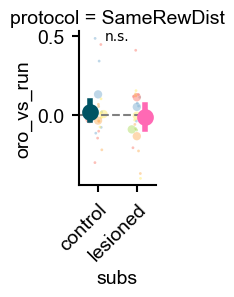

<Figure size 300x200 with 0 Axes>

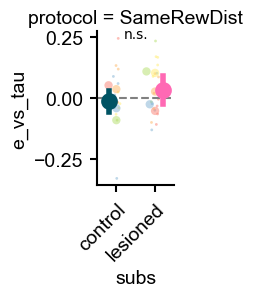

<Figure size 300x200 with 0 Axes>

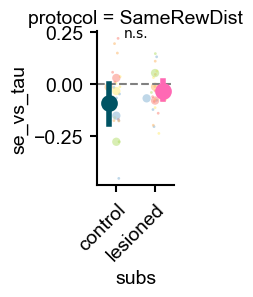

<Figure size 300x200 with 0 Axes>

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


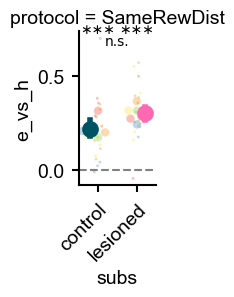

<Figure size 300x200 with 0 Axes>

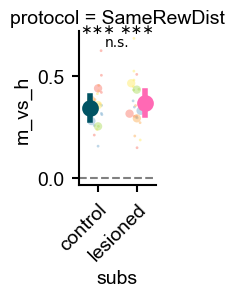

<Figure size 300x200 with 0 Axes>

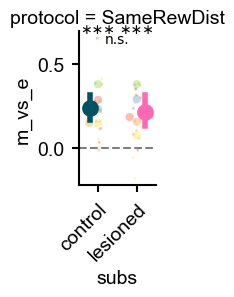

<Figure size 300x200 with 0 Axes>

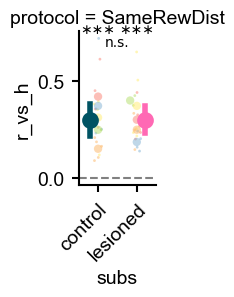

<Figure size 300x200 with 0 Axes>

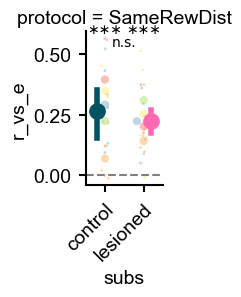

<Figure size 300x200 with 0 Axes>

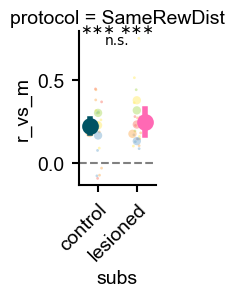

<Figure size 300x200 with 0 Axes>

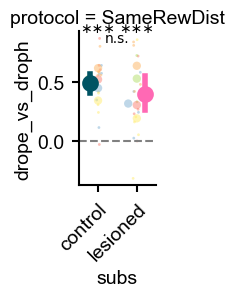

<Figure size 300x200 with 0 Axes>

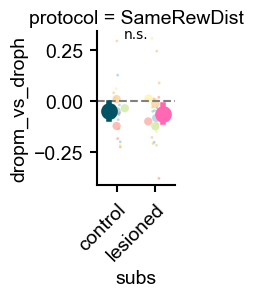

<Figure size 300x200 with 0 Axes>

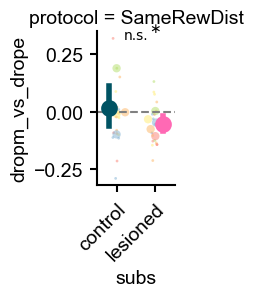

<Figure size 300x200 with 0 Axes>

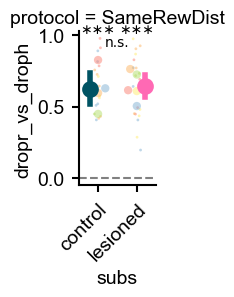

<Figure size 300x200 with 0 Axes>

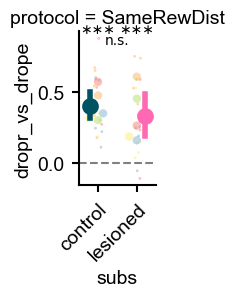

<Figure size 300x200 with 0 Axes>

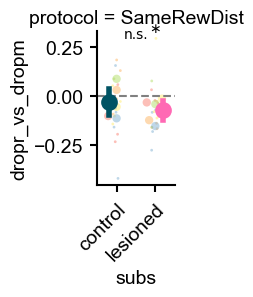

In [108]:
# plot within-session correlations and compute statistics
sess_df_mouse_avg = sess_df.groupby(['names', 'protocol', 'subtype', 'subs'], as_index=False).mean()
for subtype, order, palette in zip(['cls', 'macro', 'func'], [class_labels, ['Ventral', 'Dorsal'], subs],
                                   [cls_palette, macro_palette, subs_palette]):
    
    sub_df = sess_df_mouse_avg[sess_df_mouse_avg['subtype'] == subtype]
    for corrvar in corr_names:
        plt.figure()
        aspect=(len(order) + 3) / 5 if len(order) > 2 else .5
        g = sns.FacetGrid(data=sub_df, col='protocol', col_order=protocols, height=2, aspect=aspect, sharey=False, 
                          gridspec_kws={'wspace': 0.3, 'hspace': 0.5})
        g.map_dataframe(sns.swarmplot, x='subs', y=corrvar, hue='names', order=order, alpha=.5, legend=False, zorder=1, size=6, palette=mouse_colors)
        # g = sns.catplot(data=sub_df, col='protocol', col_order=protocols, height=2, aspect=(len(order) + 3) / 5, x='subs', y=corrvar, 
        #                 hue='names', order=order, alpha=.5, kind='swarm', legend=False, zorder=1, size=6, palette=mouse_colors)
        [sns.stripplot(data=sess_df[np.logical_and(sess_df['protocol'] == prot, sess_df['subtype'] == subtype)], x='subs', y=corrvar, hue='names', order=order, size=2, alpha=.5, 
                       legend=False, zorder=0, ax=ax, palette=mouse_colors) for ax, prot in zip(g.axes.flat, protocols)]
        g.map_dataframe(sns.pointplot, x='subs', y=corrvar, hue='subs', markersize=10, dodge=0.4, order=order, palette=palette, zorder=5,
                        err_kws={'linewidth': 4}, errorbar=('ci', 95))
        g.refline(y=0)
        [ax.set_xticks(np.arange(len(order))) for ax in g.axes.flat]
        [ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor') for ax in g.axes[0]]
        
        # MLE stats
        # for i_sub, sub in enumerate(col_order):
        for i_prot, prot in enumerate(protocols):
            
            if len(order) == 2:
                print('Across {}'.format(class_name))
                use_df = sess_df.loc[np.logical_and(sess_df['protocol'] == prot, sess_df['subtype'] == subtype), ['names', corrvar]].dropna()
                if len(np.unique(use_df['names'])) > 1 and len(use_df) > 2:
                    model = mixedlm('{} ~ C(subs)'.format(corrvar),
                                    sess_df.loc[np.logical_and(sess_df['protocol'] == prot, sess_df['subtype'] == subtype)].dropna(), groups='names')
                    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                    print(mfit.summary())
                    pvals = mfit.summary().tables[1][-len(order):-1]['P>|z|'].values
                    pvals = np.array([np.float64(x) if x != '' else 1. for x in pvals])
                else: pvals = [1]
                plot_stars(g.axes.flat[i_prot], [0.5], pvals, ytop_scale=0.9, show_ns=True)

            pvals = []
            for sub in order:
                print(sub)
                use_df = sess_df.loc[np.logical_and.reduce([sess_df['protocol'] == prot, sess_df['subs'] == sub, 
                                                            sess_df['subtype'] == subtype]), ['names', corrvar]].dropna()
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    if len(np.unique(use_df['names'])) > 1 and len(use_df) > 2:
                        model = mixedlm('{} ~ 1'.format(corrvar), use_df, groups='names')
                        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                        if i_prot == 0:
                            print(mfit.summary())
                        tmp = mfit.summary().tables[1]['P>|z|'][0]
                        pvals.append(1 if tmp == '' else float(tmp))
                    else: pvals.append(1)
            plot_stars(g.axes.flat[i_prot], np.arange(len(order)), pvals)
        [plt.savefig('./glm_figs/{}_across_{}_{}_corr_reg_{}_l1_{}.{}'.format(corrvar, subtype, manipulation, reg, l1_ratio, ext)) for ext in fmts]
    break

In [109]:
median_cols = [col for col in merge.columns if 'dev' in col or 'diff' in col]
agg_dict = {col: 'median' for col in median_cols}

mean_cols = [col for col in merge.columns if 'inds' in col or 'tau' in col or 'tuning' in col]
mean_dict = {col: 'mean' for col in mean_cols}

agg_dict.update(mean_dict)

# data limited to str_regions
incl_df = merge[np.isin(merge[class_name], class_labels)]

In [110]:
# aggregate the data, either all neurons or only history/expectiles/motor inds
incl = {}
ind_size = 10
# for ephys, treat each session independently, but for imaging, ignore session and just average over neurons
sess_level = [] if table == 'imaging' else ['file_dates']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for subset, subset_name in zip([incl_df['trim_dev_expl'] > cutoff, np.ones(len(incl_df), dtype=bool), incl_df['history_inds'],
                                    incl_df['expectiles_inds'], incl_df['motor_inds'], incl_df['reward_inds']],
                                   ['good', 'all', 'history', 'expectiles', 'motor', 'reward']):

        # restrict statistics to sessions with at least ind_size of the relevant neurons (because we're computing fraction of inds)
        incl_date_subr = incl_df[subset].groupby(['names', class_name, 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', class_name, 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        incl_subr_sess = incl_date_subr.groupby(['names', class_name, 'protocol'], as_index=False).mean()  # mean across sessions
        
        incl_date = incl_df[subset].groupby(['names', 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        incl_sess = incl_date.groupby(['names', 'protocol'], as_index=False).mean()
    
        incl_macro_sess = incl_df[subset].copy()
        # incl_macro_sess['macro_regions'] = 'Ventral'
        # incl_macro_sess.loc[np.isin(incl_macro_sess['str_regions'], ['VMS', 'VLS', 'DMS', 'DLS']), 'macro_regions'] = 'Dorsal'
        incl_macro_sess[class_name] = incl_macro_sess['macro_regions']
        incl_macro_sess = incl_macro_sess.groupby(['names', class_name, 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', class_name, 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        # incl_macro_sess = incl_macro_sess.groupby(['names', class_name, 'protocol'], as_index=False).mean()
    
        incl[subset_name] = {'neuron': incl_df[subset], 'date_subr': incl_date_subr, 'subr_sess': incl_subr_sess, 'date': incl_date, 'sess': incl_sess, 'macro_sess': incl_macro_sess}

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                       Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         trim_dev_expl
No. Observations:          4879            Method:                     REML         
No. Groups:                5               Scale:                      0.0155       
Min. group size:           458             Log-Likelihood:             3163.4057    
Max. group size:           1342            Converged:                  Yes          
Mean group size:           975.8                                                    
------------------------------------------------------------------------------------
                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------
Intercept              9.478e-02 1.690e-02  5.609e+00 2.037e-08  6.166e-02 1.279e-01
C(lesion)[T.lesioned] -5.159e-03 2.413e-02 -2.138e-01 8.307e-01 -5.245e-02 4.213e-02
file

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         history_diff
No. Observations:         4879            Method:                     REML        
No. Groups:               5               Scale:                      0.0008      
Min. group size:          458             Log-Likelihood:             10492.4425  
Max. group size:          1342            Converged:                  Yes         
Mean group size:          975.8                                                   
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             4.272e-03 8.989e-04 4.753e+00 2.008e-06  2.510e-03 6.034e-03
C(lesion)[T.lesioned] 5.939e-04 1.253e-03 4.738e-01 6.356e-01 -1.863e-03 3.051e-03
file_dates Var        8.338

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                       Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        expectiles_diff
No. Observations:          4879           Method:                    REML           
No. Groups:                5              Scale:                     0.0010         
Min. group size:           458            Log-Likelihood:            9793.5709      
Max. group size:           1342           Converged:                 Yes            
Mean group size:           975.8                                                    
------------------------------------------------------------------------------------
                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------
Intercept              1.075e-02 1.762e-03  6.104e+00 1.037e-09  7.301e-03 1.421e-02
C(lesion)[T.lesioned] -4.348e-04 2.488e-03 -1.748e-01 8.613e-01 -5.312e-03 4.442e-03
file

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         motor_diff
No. Observations:           4879            Method:                     REML      
No. Groups:                 5               Scale:                      0.0038    
Min. group size:            458             Log-Likelihood:             6638.1791 
Max. group size:            1342            Converged:                  Yes       
Mean group size:            975.8                                                 
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             5.024e-02 4.721e-03 1.064e+01 1.908e-26  4.099e-02 5.950e-02
C(lesion)[T.lesioned] 3.344e-03 6.704e-03 4.988e-01 6.179e-01 -9.796e-03 1.648e-02
file_dates Var        3.992

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         reward_diff
No. Observations:          4879            Method:                     REML       
No. Groups:                5               Scale:                      0.0010     
Min. group size:           458             Log-Likelihood:             9777.8652  
Max. group size:           1342            Converged:                  Yes        
Mean group size:           975.8                                                  
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.008e-02 1.313e-03 7.679e+00 1.603e-14  7.508e-03 1.265e-02
C(lesion)[T.lesioned] 9.050e-04 1.841e-03 4.916e-01 6.230e-01 -2.703e-03 4.513e-03
file_dates Var        2.325

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      total_history_tuning
No. Observations:       4879         Method:                  REML                
No. Groups:             5            Scale:                   0.0578              
Min. group size:        458          Log-Likelihood:          -16.6385            
Max. group size:        1342         Converged:               Yes                 
Mean group size:        975.8                                                     
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.379e-01 1.605e-02 8.596e+00 8.261e-18  1.065e-01 1.694e-01
C(lesion)[T.lesioned] 1.083e-02 2.274e-02 4.765e-01 6.337e-01 -3.373e-02 5.540e-02
file_dates Var        4.455

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    total_abs_expectiles_tuning
No. Observations:    4879       Method:                REML                       
No. Groups:          5          Scale:                 0.1672                     
Min. group size:     458        Log-Likelihood:        -2620.7852                 
Max. group size:     1342       Converged:             Yes                        
Mean group size:     975.8                                                        
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             2.285e-01 3.742e-02 6.108e+00 1.008e-09  1.552e-01 3.019e-01
C(lesion)[T.lesioned] 4.038e-02 5.324e-02 7.585e-01 4.482e-01 -6.397e-02 1.447e-01
file_dates Var        2.587

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       total_motor_tuning
No. Observations:       4879          Method:                   REML              
No. Groups:             5             Scale:                    0.1675            
Min. group size:        458           Log-Likelihood:           -2619.7004        
Max. group size:        1342          Converged:                Yes               
Mean group size:        975.8                                                     
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             4.260e-01 3.205e-02 1.329e+01 2.575e-40  3.632e-01 4.888e-01
C(lesion)[T.lesioned] 6.635e-02 4.552e-02 1.458e+00 1.449e-01 -2.286e-02 1.556e-01
file_dates Var        1.847

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      total_reward_tuning
No. Observations:        4879         Method:                  REML               
No. Groups:              5            Scale:                   0.0911             
Min. group size:         458          Log-Likelihood:          -1132.5176         
Max. group size:         1342         Converged:               Yes                
Mean group size:         975.8                                                    
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.763e-01 2.326e-02 7.579e+00 3.476e-14  1.307e-01 2.218e-01
C(lesion)[T.lesioned] 5.617e-02 3.302e-02 1.701e+00 8.893e-02 -8.549e-03 1.209e-01
file_dates Var        9.685

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         history_inds
No. Observations:         39              Method:                     REML        
No. Groups:               5               Scale:                      0.0031      
Min. group size:          3               Log-Likelihood:             49.2349     
Max. group size:          9               Converged:                  Yes         
Mean group size:          7.8                                                     
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             8.884e-02 1.859e-02 4.778e+00 1.771e-06  5.239e-02 1.253e-01
C(lesion)[T.lesioned] 2.686e-03 1.790e-02 1.500e-01 8.807e-01 -3.240e-02 3.778e-02
names Var             8.897

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        expectiles_inds
No. Observations:        39             Method:                    REML           
No. Groups:              5              Scale:                     0.0119         
Min. group size:         3              Log-Likelihood:            23.1828        
Max. group size:         9              Converged:                 Yes            
Mean group size:         7.8                                                      
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             2.032e-01 4.576e-02 4.441e+00 8.960e-06  1.135e-01 2.929e-01
C(lesion)[T.lesioned] 1.096e-02 3.520e-02 3.114e-01 7.555e-01 -5.803e-02 7.995e-02
names Var             7.148

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         motor_inds
No. Observations:           39              Method:                     REML      
No. Groups:                 5               Scale:                      0.0157    
Min. group size:            3               Log-Likelihood:             17.6069   
Max. group size:            9               Converged:                  Yes       
Mean group size:            7.8                                                   
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             4.751e-01 5.836e-02 8.142e+00 3.897e-16  3.607e-01 5.895e-01
C(lesion)[T.lesioned] 5.540e-02 4.050e-02 1.368e+00 1.713e-01 -2.397e-02 1.348e-01
names Var             1.255

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         reward_inds
No. Observations:          39              Method:                     REML       
No. Groups:                5               Scale:                      0.0070     
Min. group size:           3               Log-Likelihood:             33.3060    
Max. group size:           9               Converged:                  Yes        
Mean group size:           7.8                                                    
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.929e-01 3.325e-02 5.800e+00 6.649e-09  1.277e-01 2.580e-01
C(lesion)[T.lesioned] 3.508e-02 2.694e-02 1.302e+00 1.929e-01 -1.773e-02 8.789e-02
names Var             3.593

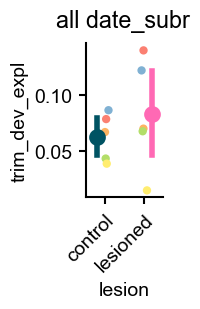

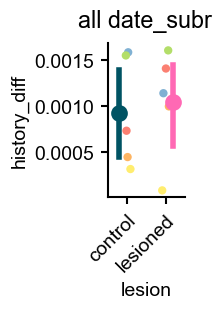

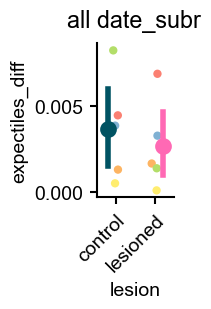

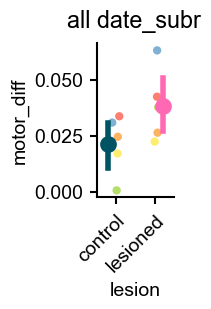

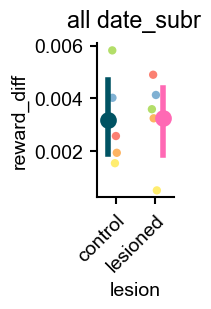

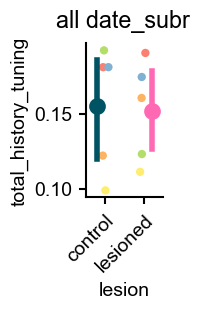

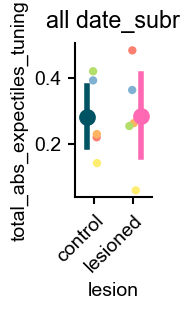

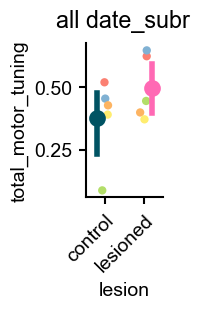

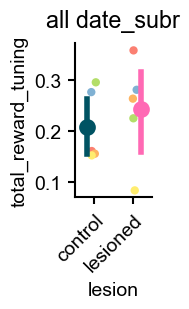

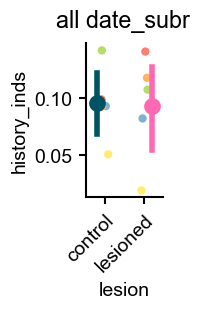

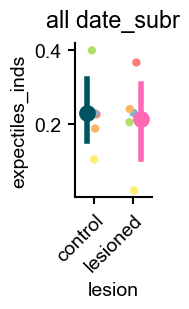

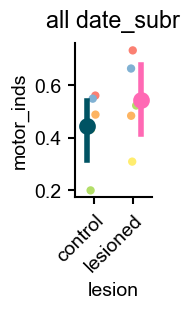

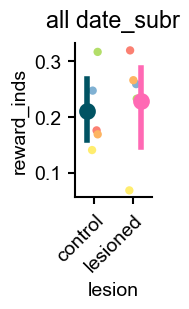

In [111]:
fmts = ['png', 'pdf']
var_inds = ['history_inds', 'expectiles_inds', 'motor_inds', 'reward_inds']

grid_kwargs = dict(col='protocol', col_order=protocols, height=2, sharey=False, gridspec_kws={'wspace': 0.3, 'hspace': 0.5})
hue_kwargs = dict(x=class_name, hue='names', palette=mouse_colors, zorder=1, legend=False)
mean_kwargs = dict(x=class_name, hue=class_name, err_kws={'linewidth': 4}, errorbar=('ci', 95), zorder=10)

for subset_name, extras in zip(['all', 'good', 'expectiles', 'history', 'motor', 'reward'], 
                               [var_inds, var_inds, ['pref_tau'], [], [], []]):
# for subset_name, extra in zip(['all', 'history', 'expectiles', 'motor'], ['expectiles_inds', 'total_history_tuning', 'pref_tau', 'frac_orofacial_tuning']):
# for subset_name, extra in zip(['all'], ['expectiles_inds']):
    for reg_spec, palette, order in zip(['date_subr', 'macro_sess'], [cls_palette, macro_palette], [class_labels, ['Ventral', 'Dorsal']]):

        neuron_data = incl[subset_name]['neuron']
        sess_data = incl[subset_name][reg_spec]
       
        for depvar in ['trim_dev_expl', 'history_diff', 'expectiles_diff', 'motor_diff', 'reward_diff', 'total_history_tuning',
                       'total_abs_expectiles_tuning', 'total_motor_tuning', 'total_reward_tuning', *extras]:

            if depvar in extras:
                data = sess_data.groupby(['names', class_name, 'protocol'], as_index=False).mean()
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    data = neuron_data.groupby(['names', class_name, 'protocol'], as_index=False).agg(agg_dict)

            aspect=((len(order) + 3) / 5) if len(order) > 2 else .5
            g = sns.FacetGrid(data=data, aspect=aspect, **grid_kwargs)
            if order == class_labels:
                [ax.set_xticks(np.arange(len(order))) for ax in g.axes.flat]
                [ax.set_xticklabels(class_labels, rotation=45, ha='right', rotation_mode='anchor') for ax in g.axes.flat]
            figtitle = "{} {}".format(subset_name, reg_spec)
            g.fig.suptitle(figtitle, y=1.05)
            
            try:
                g.map_dataframe(sns.stripplot, y=depvar, order=order, size=6, **hue_kwargs)
                g.map_dataframe(sns.pointplot, y=depvar, order=order, palette=palette, markersize=10, dodge=0.4, **mean_kwargs).set_titles("")                    
                # g = sns.catplot(data=data, x=class_name, y=depvar, hue='names', col='protocol', order=order, kind='strip', size=4,
                #                 legend=False, col_order=protocols, height=3, palette=mouse_colors)  # markers=None, linewidth=1,
                # g.map_dataframe(sns.pointplot, x=class_name, y=depvar, hue=class_name, order=order, legend=False, linestyles='',
                #                 linewidth=3, palette=palette)
                
            except ZeroDivisionError:
                pass         

            # MLE stats
            # for i_sub, sub in enumerate(col_order):
            for i_prot, prot in enumerate(protocols):
                if depvar in extras:  # session level
                    use_df = sess_data.loc[sess_data['protocol'] == prot, ['names', class_name, depvar]].dropna()
                    vc_formula = None
                else:
                    use_df = neuron_data.loc[neuron_data['protocol'] == prot, ['names', class_name, depvar, 'file_dates']].dropna()
                    vc_formula = {'file_dates': '0 + C(file_dates)'}
                    # print(neuron_data[neuron_data['protocol'] == prot])
                    # print(use_df)
                with warnings.catch_warnings():
                    try:
                        warnings.simplefilter('ignore')
                        model = mixedlm('{} ~ C({})'.format(depvar, class_name), use_df, vc_formula=vc_formula, groups='names')
                        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                        print(mfit.summary())
                    except LinAlgError:
                        continue
                    regions = mfit.summary().tables[1][-len(order):-1].index
                    reg_ind = [np.flatnonzero([regstr in reg for reg in regions]) for regstr in order]
                    reg_ind_flat = np.array([x[0] for x in reg_ind if x.size > 0])
                    centers = np.flatnonzero([x.size > 0 for x in reg_ind])
                    if reg_ind_flat.size > 0:
                        pvals = mfit.summary().tables[1][-len(order):-1]['P>|z|'].values
                        pvals = np.array([np.float64(x) if x != '' else 1. for x in pvals])
                        plot_stars(g.axes.flat[i_prot], centers, pvals[reg_ind_flat])
                
                    # pvals = []
                    # # for protocol in protocols:
                    # for sub in order:
                    #     use_df = sess_data.loc[np.logical_and(sess_data['protocol'] == prot, sess_data['str_regions'] == sub), ['names', depvar]].dropna()
                    #     if len(use_df) > 1:
                    #         model = mixedlm('{} ~ 1'.format(depvar), use_df, groups='names')
                    #         mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                    #         print(mfit.summary())
                    #         tmp = mfit.summary().tables[1]['P>|z|'][0]
                    #         pvals.append(1 if tmp == '' else float(tmp))
                    #     else: pvals.append(1)
                    # plot_stars(g.axes.flat[i_prot], np.arange(len(order)), pvals, ytop_scale=1.1)
            
            [plt.savefig('./glm_figs/{}_{}_{}_reg_{}_l1_{}.{}'.format(figtitle, depvar, manipulation, reg, l1_ratio, fmt)) for fmt in fmts]
        break  # stop after subregion breakdown, don't bother doing macro
    break  # stop after all subset
            